# Appearance feature extraction with ResNet18

In [1]:
%load_ext autoreload
%autoreload 2

## Preparing the Bounding Boxes Dataset

In [2]:
import soccertrack
from soccertrack import detection_model
from soccertrack.utils import get_git_root, cv2pil
from soccertrack import Camera
from pathlib import Path
import cv2


def crop_bbox(x, y, w, h, frame):
    # crop bounding box from frame
    return frame[y : y + h, x : x + w]


root = get_git_root()

dataset_path = soccertrack.datasets.get_path("top-view")
path_to_csv = sorted(dataset_path.glob("annotations/*.csv"))[0]
path_to_mp4 = sorted(dataset_path.glob("videos/*.mp4"))[0]

frame_num = 0  # Frame number to extract features from
bbdf = soccertrack.load_df(path_to_csv)  # We will use this as ground truth
bbdf = bbdf.drop("3", level="TeamID", axis=1)  # Drop ball information

cam = Camera(path_to_mp4)  # Camera object will be used to load frames

dataset_root = Path(root) / "data" / "appearance_extractor"
trainset_path = Path(dataset_root) / "trainset"
valset_path = Path(dataset_root) / "valset"
testset_path = Path(dataset_root) / "testset"

dataset_paths = [trainset_path, valset_path, testset_path]

# extract bounding boxes from frame
for frame_num, frame in enumerate(cam.iter_frames()):

    for (team_id, player_id), bb in bbdf.get_frame(frame_num).iter_players():
        save_path = dataset_path / f"{team_id}/{player_id}_{frame_num}.png"
        if save_path.exists():
            continue

        bb = bb.astype(int).values[0]
        bbox_image = crop_bbox(*bb[:4], frame)

        if frame_num < 900 * 2 / 3:
            dataset_path = trainset_path
        elif frame_num < 900 * 5 / 6:
            dataset_path = valset_path
        else:
            dataset_path = testset_path

        save_path.parent.mkdir(parents=True, exist_ok=True)

        # save image to disk
        cv2.imwrite(str(save_path), bbox_image)

/Users/atom/Library/Caches/pypoetry/virtualenvs/soccertrack-KNSgM8DD-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train the classifier (using Lightning Flash)

### 1. Create the DataModule

In [3]:
import torch
import torchmetrics
from torchvision import transforms, models
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image

class DataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int = 32, im_size: int = 32, num_workers: int = 4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.im_size = im_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize((im_size, im_size)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
            ),
        ])

        self.dims = (3, im_size, im_size)
        self.num_classes = 2

    def setup(self, stage=None):
        self.trainset = ImageFolder(self.data_dir / 'trainset', transform=self.transform)
        self.valset = ImageFolder(self.data_dir / 'valset', transform=self.transform)
        self.testset = ImageFolder(self.data_dir / 'testset', transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, num_workers=self.num_workers)

dm = DataModule(
    data_dir=dataset_root,
    batch_size=16,
)

dm.setup()
im, label = dm.trainset[0]
print(f'image shape: {im.shape}, label: {label}')

image shape: torch.Size([3, 32, 32]), label: 0


### 2. Create the model

In [4]:
from torch import nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy


class LitModel(pl.LightningModule):
    def __init__(self, num_classes, hidden_size=64, learning_rate=2e-4):

        super().__init__()

        # We take in input dimensions as parameters and use those to dynamically build model.
        self.num_classes = num_classes
        self.learning_rate = learning_rate

        # init a pretrained resnet
        backbone = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]

        # add a layer with `hidden_size` units
        self.feature_extractor = nn.Sequential(
            *layers, nn.Flatten(), nn.Linear(num_filters, hidden_size)
        )

        # add a layer with `num_classes` units
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x, return_embeddings=False):
        x = self.feature_extractor(x)
        if return_embeddings:
            return x
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=self.num_classes)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=self.num_classes)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


### 3. Train the model

In [5]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

model = LitModel(num_classes=2)
trainer = pl.Trainer(max_epochs=1, accelerator="cpu")

save_path = get_git_root() / "appearance_extractor" / "resnet18"
trainer = pl.Trainer(
    default_root_dir=save_path,  # Where to save models
    # We run on a single GPU (if possible)
    accelerator='cpu',
    # How many epochs to train for if no patience is set
    max_epochs=5,
    callbacks=[
        ModelCheckpoint(
            save_weights_only=True, mode="max", monitor="val_acc"
        ),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
        LearningRateMonitor("epoch"),
    ],  # Log learning rate every epoch
)  
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/atom/Github/SoccerTrack/appearance_extractor/resnet18/lightning_logs

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 11.2 M
1 | classifier        | Linear     | 130   
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.838    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1033/1033 [03:38<00:00,  4.73it/s, loss=9.61e-05, v_num=0, val_loss=0.0359, val_acc=0.992]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1033/1033 [03:38<00:00,  4.73it/s, loss=9.61e-05, v_num=0, val_loss=0.0359, val_acc=0.992]


In [6]:
trainer.test(model, dm)

Testing DataLoader 0: 100%|██████████| 207/207 [00:20<00:00,  9.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9896969795227051     │
│         test_loss         │    0.04843287914991379    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.04843287914991379, 'test_acc': 0.9896969795227051}]

## Using the trained classifier as a feature extractor

In [7]:
from soccertrack.logger import tqdm

# set model to eval mode
model.eval()

# modify the model to output embeddings
gts = []
embs = torch.empty(0, 64)
for batch_num, x in tqdm(enumerate(dm.test_dataloader())):
    with torch.no_grad():
        emb = model(x[0], return_embeddings=True)

    gts = gts + x[1].tolist()
    embs = torch.concatenate((emb, embs))

207it [00:41,  4.99it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3300 samples in 0.000s...
[t-SNE] Computed neighbors for 3300 samples in 0.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3300
[t-SNE] Computed conditional probabilities for sample 2000 / 3300
[t-SNE] Computed conditional probabilities for sample 3000 / 3300
[t-SNE] Computed conditional probabilities for sample 3300 / 3300
[t-SNE] Mean sigma: 0.164578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.186214
[t-SNE] KL divergence after 300 iterations: 1.469738


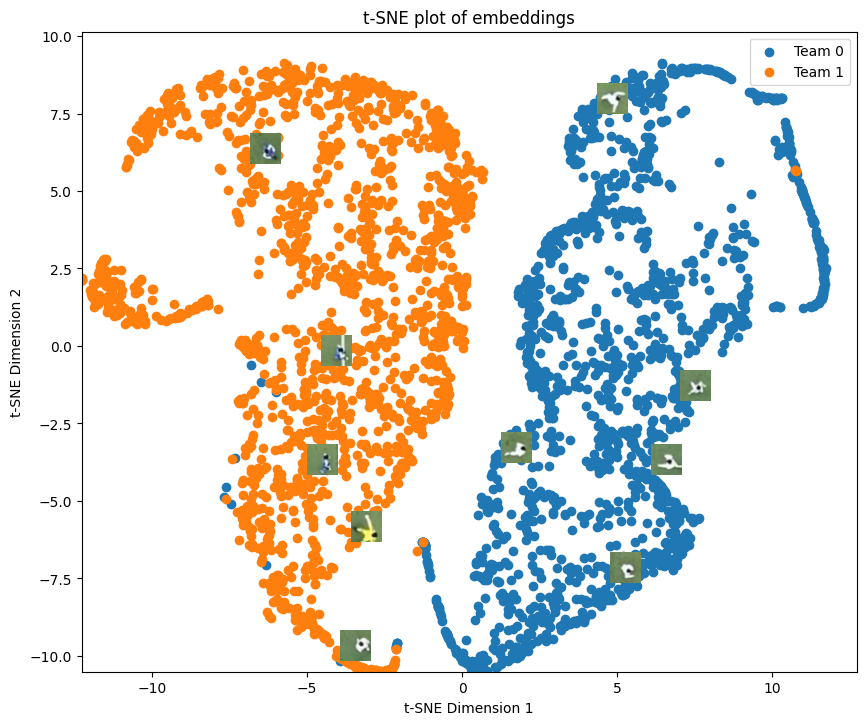

In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from random import choice

# unnormalize the image
def unnormalize(im):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    im = im * std[:, None, None] + mean[:, None, None]
    return im.numpy().transpose(1, 2, 0)

# generate t-SNE embeddings
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)

# plot t-SNE results with ground truth labels and color by team
fig, ax = plt.subplots(figsize=(10, 10))

for team in [0, 1]:
    ax.scatter(
        tsne_results[np.array(gts) == team, 0],
        tsne_results[np.array(gts) == team, 1],
        c=f"C{team}",
        label=f"Team {team}",
    )

# set plot x and y limits
ax.set_xlim(tsne_results[:, 0].min(), tsne_results[:, 0].max() + 1)
ax.set_ylim(tsne_results[:, 1].min(), tsne_results[:, 1].max() + 1)
plt.title("t-SNE plot of embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# plot some images on top of the t-SNE plot
for i in np.random.choice(range(len(dm.testset)), size=10):
        data = dm.testset[i]
        data_input = data[0]# torch tensor
        data_input = unnormalize(data_input) # convert to numpy array
        data_target = data[1] # ground truth label
        data_emb = embs[i] # embedding
        
        # plot image at the embedding location
        ax.imshow(
            data_input,
            extent=(
                tsne_results[i, 0],
                tsne_results[i, 0] + 1,
                tsne_results[i, 1],
                tsne_results[i, 1] + 1,
            ),
            zorder=1,
        )

plt.legend()
plt.show()